# Solera Test

# Loading the dataset

In [2]:
import pyspark
import pyspark.sql
from pyspark.sql import SparkSession

#Create the SparkSession
spark = SparkSession \
    .builder \
    .appName("Solera Tset") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
    
#Loading the dataset 
df_dataset = spark.read.parquet("/home/kathrin-laptop/Desktop/Test-Solera/zubie_trips_anonymous/")

# Inspecting the dataset

In [3]:
# Get the dataset schema
df_dataset.printSchema()

root
 |-- device_key: string (nullable = true)
 |-- distance_um: string (nullable = true)
 |-- duration_seconds: double (nullable = true)
 |-- end_point_address_city: string (nullable = true)
 |-- end_point_address_country: string (nullable = true)
 |-- end_point_address_state: string (nullable = true)
 |-- end_point_address_zipcode: string (nullable = true)
 |-- end_point_daylight_saving_time_flag: boolean (nullable = true)
 |-- end_point_latitude: double (nullable = true)
 |-- end_point_longitude: double (nullable = true)
 |-- end_point_place: string (nullable = true)
 |-- end_point_timestamp: string (nullable = true)
 |-- end_point_timestamp_tz: string (nullable = true)
 |-- end_point_timestamp_utc: string (nullable = true)
 |-- fuel_consumed: string (nullable = true)
 |-- fuel_consumed_um: string (nullable = true)
 |-- fuel_cost: string (nullable = true)
 |-- fuel_cost_currency_code: string (nullable = true)
 |-- fuel_cost_currency_symbol: string (nullable = true)
 |-- fuel_ppg: st

In [11]:
#Get the number of columns
len(df_dataset.columns)

56

In [6]:
#Get the number of rows
df_dataset.count()

28952

In [4]:
#Visuale two first rows
df_dataset.take(2)

[Row(device_key='agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM', distance_um='mi', duration_seconds=425.0, end_point_address_city='Cleckheaton', end_point_address_country='GB', end_point_address_state='England', end_point_address_zipcode='BD19 3TY', end_point_daylight_saving_time_flag=False, end_point_latitude=53.732082, end_point_longitude=-1.717613, end_point_place=None, end_point_timestamp='2016-11-24 12:33:01', end_point_timestamp_tz='GMT', end_point_timestamp_utc='2016-11-24 12:33:01', fuel_consumed=None, fuel_consumed_um='gal', fuel_cost=None, fuel_cost_currency_code='EUR', fuel_cost_currency_symbol='€', fuel_ppg='2.39', fuel_type='regular', gps_distance=0.7478155691835856, gps_miles=0.7478155691835856, hard_accel_count=0, hard_brake_count=0, idle_seconds=238, key='agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWUmVUaEpUNlFaRmJhQ1IyREtTTmFSNww', mpg_combined=None, obd_distance=0.7810635886423287, obd_miles=0.7810635886423287, points_

# Question 1: Cleaning the dataset

# Step1 Droping duplicated rows and applying other filters

In [12]:
#Drop rows only if all their values are null
filtered_Dataset = df_dataset.dropna(how='all')
filtered_Dataset.count()

28952

In [13]:
#Drop duplicated rows
filtered_Dataset = df_dataset.dropDuplicates()
filtered_Dataset.count()

5295

In [20]:
#Assuming that "key" is a unique identifier for each trip, then:

from pyspark.sql.functions import *

#rows with duplicated key' value are removed from the dataset
filtered_Dataset = filtered_Dataset.dropDuplicates(['key'])

#rows where "key" has null values are removed from the dataset
filtered_Dataset = filtered_Dataset.where(col('key').isNotNull())

filtered_Dataset.count()

5248

# Step2 Detect the columns in which all their values are null

In [21]:
#Detect the columns in which all their values are null
nullColumns = []
numRows = filtered_Dataset.count()
for k in filtered_Dataset.columns:
    nullRows = filtered_Dataset.where(col(k).isNull()).count()#return the number of null rows for a column
    if nullRows ==  numRows: # all values are null
        nullColumns.append(k)

nullColumns

['end_point_place',
 'fuel_consumed',
 'fuel_cost',
 'mpg_combined',
 'start_point_place',
 'user']

In [22]:
#Drop null columns from the dataset
filtered_Dataset = filtered_Dataset\
.select([column for column in filtered_Dataset.columns if column not in nullColumns])

In [23]:
#test
len(filtered_Dataset.columns)

50

# Step3 Detect the columns in which all their values are the same

In [24]:
#Detect the columns in which all their values are the same
uniformColumns = []
numRows = filtered_Dataset.count()#the number of columns doesn't include the nullColumns
for k in filtered_Dataset.columns:
    # discard null values
    equalRows = filtered_Dataset.groupby(k).count().collect()[0][1]
    if equalRows ==  numRows: # i.e. the number of rows with the same values = total number of rows
        uniformColumns.append(k)

uniformColumns

['distance_um', 'fuel_consumed_um', 'speed_um', 'tags', 'trip_segments']

In [25]:
#drop uniform columns from the dataset
filtered_Dataset = filtered_Dataset\
.select([column for column in filtered_Dataset.columns if column not in uniformColumns])

In [26]:
#test
len(filtered_Dataset.columns)

45

# Step4 Other logic filter

In [27]:
#Since the same device can not start two trips at the same time, then:
#those trips(rows) that have the same value for the pair [device_key,start_point_timestamp] are removed
filtered_Dataset = filtered_Dataset.dropDuplicates(['device_key', 'start_point_timestamp'])
filtered_Dataset.count()

5248

#                             Question 2. Predictive Analytics

# Features Selection

In [28]:
#Compute the number of null values per column
nullValues = []
numRows = filtered_Dataset.count()
for k in filtered_Dataset.columns:
    nullRows = filtered_Dataset.where(col(k).isNull()).count()#return the number of null rows for a column
    nullValues.append((k, nullRows))

#sorting nullValues Tuple by the number of null values 
nullValues.sort(key=lambda x: x[1])
nullValues

[('device_key', 0),
 ('fuel_cost_currency_code', 0),
 ('fuel_cost_currency_symbol', 0),
 ('hard_accel_count', 0),
 ('hard_brake_count', 0),
 ('key', 0),
 ('start_point_daylight_saving_time_flag', 0),
 ('start_point_latitude', 0),
 ('start_point_longitude', 0),
 ('start_point_timestamp', 0),
 ('start_point_timestamp_utc', 0),
 ('static_map_url', 0),
 ('vehicle_key', 0),
 ('vehicle_nickname', 0),
 ('top_speed', 3),
 ('top_speed_mph', 3),
 ('duration_seconds', 31),
 ('end_point_daylight_saving_time_flag', 31),
 ('end_point_latitude', 31),
 ('end_point_longitude', 31),
 ('end_point_timestamp', 31),
 ('end_point_timestamp_utc', 31),
 ('fuel_ppg', 31),
 ('fuel_type', 31),
 ('obd_distance', 33),
 ('obd_miles', 33),
 ('idle_seconds', 57),
 ('start_point_address_country', 60),
 ('start_point_address_state', 73),
 ('end_point_address_country', 81),
 ('start_point_address_zipcode', 81),
 ('start_point_timestamp_tz', 94),
 ('end_point_address_zipcode', 104),
 ('end_point_address_state', 118),
 ('e

In [29]:
len(nullValues)

45

In [ ]:
#Since the number of columns in the dataset is relatively small(45), 
#it is possible to manually select the features that will be used to build the model. 
#Otherwise I can apply a feature selection algorithm 
#(Ex: Reference --> D. Zongker, "Algorithms for feature selection: An evaluation", 1996)

#Firt we devide the features in 6 categories(Identification, Geolocation, Time, Distance, Speed and Cost)

#Identification (4 features)
"""
1- (‘key', 'string')
2 -('device_key', 'string')
3 -('vehicle_key', 'string'),
4 -('vehicle_nickname', 'string')]
"""

#Geolocation (13 features)
"""
5- ('end_point_address_city', 'string')
6 -('end_point_address_country', 'string')
7 -('end_point_address_state', 'string')
8 -('end_point_address_zipcode', 'string')
9 -('end_point_latitude', 'double')
10-('end_point_longitude', 'double')
11-('start_point_address_city', 'string'),
12-('start_point_address_country', 'string'),
13-('start_point_address_state', 'string'),
14-('start_point_address_zipcode', 'string'),
15-('start_point_latitude', 'double'),
16-('start_point_longitude', 'double'),
17-('static_map_url', 'string')
"""

#Time (9 features)
"""
18-('duration_seconds', 'double')
end point
19-('end_point_daylight_saving_time_flag', 'boolean')
20-('end_point_timestamp', 'string')
21-('end_point_timestamp_tz', 'string')
22-('end_point_timestamp_utc', 'string')
start point
23-('start_point_daylight_saving_time_flag', 'boolean'),
24-('start_point_timestamp', 'string'),
25-('start_point_timestamp_tz', 'string')
26-('start_point_timestamp_utc', 'string')"
"""
    
#Distance (6 features)
"""
27-('gps_distance', 'double')
28-('gps_miles', 'double')
29-('obd_distance', 'double')
30-('obd_miles', 'double')
31-('points_city_count', 'bigint'),
32-('points_hwy_count', 'bigint')
"""

#Speed (9 features)
"""
33-('hard_accel_count', 'bigint')
34-('hard_brake_count', 'bigint')
35-('idle_seconds', 'bigint')
36-('speeding_city_major_count', 'bigint')
37-('speeding_city_minor_count', 'bigint'),
38-('speeding_hwy_major_count', 'bigint'),
39-('speeding_hwy_minor_count', 'bigint'),
40-('top_speed', 'double'),
41-('top_speed_mph', 'double'),
"""
    
#Cost (4 features)
"""
42-('fuel_ppg', 'string')
43-('fuel_cost_currency_code', 'string')
44-('fuel_cost_currency_symbol', 'string')
45-('fuel_type', 'string')
"""

In [ ]:
The first feature selection contains
#- The Identification features do'not add anything to the prediction model, so they are discarded.
#- From Geolocation features, the most important are: 
    """
    -('start_point_latitude', 'double')
    -('start_point_longitude', 'double')
    -('end_point_latitude', 'double')
    -('end_point_longitude', 'double')
    """

#- From Time features
    """
    -('duration_seconds', 'double')
    -('start_point_timestamp', 'string')
    -('end_point_timestamp', 'string')
    -('start_point_daylight_saving_time_flag', 'boolean')
    
    The features start_point_daylight_saving_time_flag and start_point_timestamp_tz represent the same 
    concept (i.e. Season of the year in British). Specifically British Summer Time (BST)and Greewich Mean
    Time (GMT). For this reason we select only one of them (start_point_daylight_saving_time_flag).
    The same occur for the daylight_saving_time_flag and timestamp_tz of the end point. In this case these 
    last features are not used in the model.
    
    
    """
#- From Distance features the most relevant are:
   """
    -('gps_distance', 'double')
    -('gps_miles', 'double')
    -('obd_distance', 'double')
    -('obd_miles', 'double')
    
    Since all of them represent the distance between the initial and final point of the trajectory,
    I select those with less null values in the dataset
     - obd_distance has 33 null values
     - obd_miles has 33 null values
     - gps_distance has 484 null values
     - gps_miles has 484 null values
    
    Then gps_distance and gps_miles are discarded because include many rows with null values and 
    I select one between obd_distance and obd_miles (because both represent the same). 
    Firstly I verify if rows with null values for obd_distance and obd_miles match. (Next step below)
    Then obd_distance was selected  
    """
# From Speed features the most relevant are:
    """
    -('hard_accel_count', 'bigint')
    -('hard_brake_count', 'bigint')
    -('top_speed', 'double')
    -('top_speed_mph', 'double')
    """

# From Cost features no variable was selected for building the model
    """
    The cost of fuel consumed on each trip would have been an important variable to predict, but since 
    the column of fuel consumption('fuel_consumed') is completely null, then no such prediction can be made.
    """

In [31]:
#Verify if rows with null values for obd_distance and obd_miles match
filtered_Dataset.where(col("obd_distance").isNull()).select(col("obd_miles"))\
.groupby('obd_miles').count().sort(asc("obd_miles")).show()

+---------+-----+
|obd_miles|count|
+---------+-----+
|     null|   33|
+---------+-----+



The result above means that all rows(33) with null values for obd_distance also have null values for obd_miles. 

In [32]:
#Removed from the dataset rows with null values for obd_distance
df_model_dataset = filtered_Dataset.where(col('obd_distance').isNotNull())
df_model_dataset.count()               

5215

In [50]:
"""
For the purposes of the prediction of travel time it is necessary to know the time at which the trip began,
because depending on the time of day the flow of cars is greater than in others and therefore, the trip may
take longer.
So, since I need to know the schedule in which the trip began, I must remove from the dataset all the records
where start_point_timestamp is null or zero.


I also need to know the travel duration. I can get it from two ways, one from the 'duration_seconds' column
and the other one, if 'duration_seconds' column does not exist, computing the difference between
'start_point_timestamp' and 'end_point_timestamp'column values. In this last case the values 
of 'start_point_timestamp'and 'end_point_timestamp' can not be nulls.
"""
#With respecto to the previously explained, I filter the dataset

df_model_dataset = df_model_dataset.where(col('start_point_timestamp').isNotNull())\
                .where(col('duration_seconds').isNotNull() | col('end_point_timestamp').isNotNull())
    
#df_model_dataset.where( col("start_point_timestamp")!= '0000-00-00 00:00:00').count()

In [51]:
#Check if there are any rows that have null values of duration_seconds, if there is no rule discard 
#the end_point_timestamp feature from the model
df_model_dataset.where(col('start_point_timestamp').isNotNull())\
                .where(col('duration_seconds').isNotNull() & col('end_point_timestamp').isNotNull()).count()

5215

The result above shows that all the rows whose value of 'start_point_timestamp' is different from null,
they also have a non-null value for the 'duration_seconds' column. So the column column 'end_point_timestamp'
is irrelevant to the prediction model and then I don't take it into account.

# Defining predictor variables and target

In [76]:
#I'm going to build a model that predicts the travel time (duration_seconds) from the following input
#variables

#Predictor Variables
b1 = 'start_point_latitude'
b2 = 'start_point_longitude'
b3 = 'end_point_latitude'
b4 = 'end_point_longitude'
b5 = 'start_point_timestamp'
b6 = 'start_point_daylight_saving_time_flag'
b7 = 'obd_distance'
b8 = 'hard_accel_count'
b9 = 'hard_brake_count'
b10 = 'top_speed'
b11 = 'top_speed_mph'
#Target    
b12 = 'duration_seconds'

In [68]:
# Cleaning the dataset by removing rows with zeros values for columns included into the model
data = df_model_dataset.where(col('start_point_latitude')!=0)\
                                    .where(col('start_point_longitude')!=0)\
                                    .where(col('end_point_latitude')!=0)\
                                    .where(col('end_point_longitude')!=0)\
                                    .where(col('duration_seconds')!=0)\
                                    .where(col('obd_distance')!=0)\
            .select('start_point_latitude', 'start_point_longitude', 'end_point_latitude', \
                    'end_point_longitude', 'duration_seconds','start_point_timestamp', \
                    'start_point_daylight_saving_time_flag', 'obd_distance','hard_accel_count',\
                    'hard_brake_count', 'top_speed','top_speed_mph')

In [69]:
data.count()

4996

# Build the Model

In [117]:
df_data = data.toPandas()
df_data.dtypes

start_point_latitude                     float64
start_point_longitude                    float64
end_point_latitude                       float64
end_point_longitude                      float64
duration_seconds                         float64
start_point_timestamp                     object
start_point_daylight_saving_time_flag       bool
obd_distance                             float64
hard_accel_count                           int64
hard_brake_count                           int64
top_speed                                float64
top_speed_mph                            float64
dtype: object

# Normalize data types

In [118]:
#convert non-numeric to numeric variables to build the model
df_data['start_point_daylight_saving_time_flag'] = df_data['start_point_daylight_saving_time_flag']\
                                                                    .astype(int)
    
import pandas as pd
#df_data['start_point_timestamp'] = df_data['start_point_timestamp'].astype('datetime64[ns]')
df_data.start_point_timestamp = pd.to_datetime(df_data.start_point_timestamp)

#Get only the hour of Time 
df_data['start_point_timestamp'] = df_data['start_point_timestamp'].dt.hour

In [120]:
df_data.dtypes

start_point_latitude                     float64
start_point_longitude                    float64
end_point_latitude                       float64
end_point_longitude                      float64
duration_seconds                         float64
start_point_timestamp                      int64
start_point_daylight_saving_time_flag      int64
obd_distance                             float64
hard_accel_count                           int64
hard_brake_count                           int64
top_speed                                float64
top_speed_mph                            float64
dtype: object

# Test with a linear regression

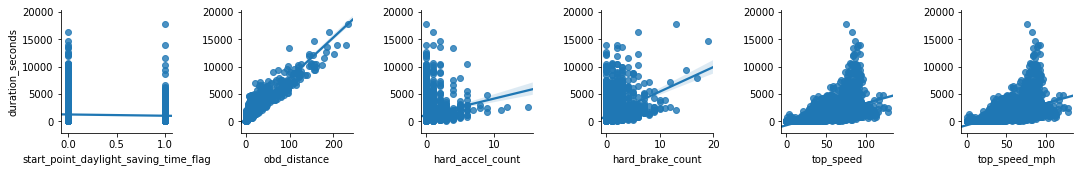

In [125]:
#Linear Regression
import seaborn as sns
%matplotlib inline
sns.pairplot(df_data, x_vars=[b6, b7, b8, b9, b10, b11], y_vars = 'duration_seconds', kind='reg')

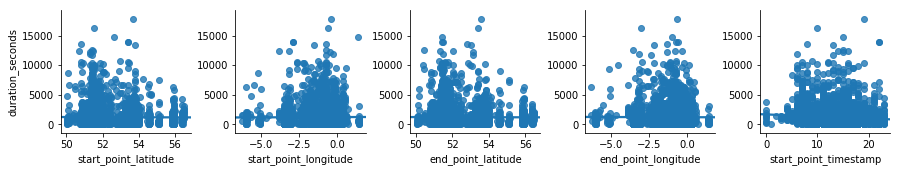

In [124]:
sns.pairplot(df_data, x_vars=[b1, b2, b3, b4, b5], y_vars = 'duration_seconds', kind='reg')

As can be seen in the graphs above, the only predictor variable that has a linear correlation 
with the target('duration_seconds') is 'obd_distance'. The others don't follow a linearity pattern. For this reason, a linear regression doesn't satisfy this scenario.   
For the cases of 'top_speed' and 'top_speed_mph' an exponential correlation is observed with respect to the target.  
Another way to discard the application of a linear regression model is computing the correlation coefficient R. It provides quantitative measurements of the statistical dependence between two variables. 

- -1 ≤  R < – 0,75% -> There is an inverse relationship between the variables.
- -0,75 ≤  R < -0,25 -> There is little inverse relationship between the variables.
- -0,25 ≤  R < 0,25 -> There is no relationship. 
- 0,25 ≤  R < 0,75 -> There is little direct relationship between the variables.
- 0,75 ≤  R  ≤ 1 -> There is a direct relationship between the variables.


R can be computed as follows.

In [128]:
#Computing the correlation coefficient
from pyspark.sql.functions import rand
R = data.stat.corr('obd_distance', 'duration_seconds')
print (R)

0.9240239452669937


# Building a Decision Tree Regression Model

Test RMSE: 587.866


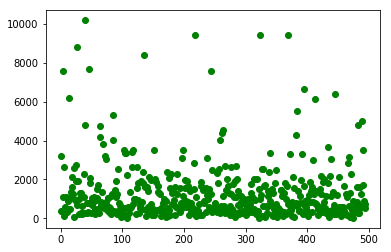

In [121]:
# DecisionTreeRegressor

from sklearn import tree
from sklearn.metrics import mean_squared_error
from math import *
import matplotlib.pyplot as plt
%matplotlib inline


# Training
feature_cols = [b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11]
X = df_data[feature_cols][1:4500]
Y = df_data['duration_seconds'][1:4500]

# Test
x_test = df_data[feature_cols][4501:]
y_test = df_data['duration_seconds'][4501:]

# Regresion Tree
clf = tree.DecisionTreeRegressor()

# Fit
clf = clf.fit(X, Y)

# Predict
predicted = clf.predict(x_test)

# RMSE
rmse = sqrt(mean_squared_error(predicted, y_test))
print('Test RMSE: %.3f' % rmse)
# Plot predicted
plt.plot(predicted, 'go')

Then we can conclude that the prediction model is able to predict the target with a small error value.

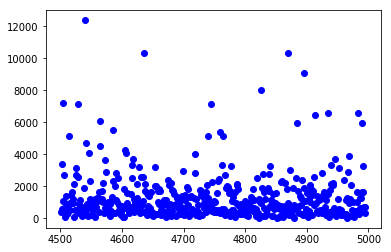

In [122]:
# Plot test
plt.plot(y_test, 'bo')

In [135]:
#Dataset statistics 
df_data.describe()

,start_point_latitude,start_point_longitude,end_point_latitude,end_point_longitude,duration_seconds,start_point_timestamp,start_point_daylight_saving_time_flag,obd_distance,hard_accel_count,hard_brake_count,top_speed,top_speed_mph
count,4996.000000,4996.000000,4996.000000,4996.000000,4996.000000,4996.000000,4996.000000,4996.000000,4996.000000,4996.000000,4996.000000,4996.000000
mean,52.291508,-1.166342,52.291477,-1.167080,1227.829965,13.437950,0.211369,9.231774,0.224780,0.585468,47.491654,47.491654
std,1.413302,1.159928,1.412608,1.159152,1490.693962,4.251638,0.408320,18.635732,0.809425,1.304839,20.628793,20.628793
min,50.036270,-6.292640,50.036270,-6.255982,18.000000,0.000000,0.000000,0.000621,0.000000,0.000000,0.000000,0.000000
25%,51.392896,-1.772987,51.392478,-1.772738,408.750000,10.000000,0.000000,1.531059,0.000000,0.000000,32.900000,32.900000
50%,51.549172,-0.787138,51.555002,-0.786856,754.000000,13.000000,0.000000,3.439600,0.000000,0.000000,43.500000,43.500000
75%,53.468588,-0.339698,53.457289,-0.339764,1491.250000,17.000000,0.000000,9.560883,0.000000,1.000000,60.900000,60.900000
max,56.521408,1.437023,56.494875,1.436827,17805.000000,23.000000,1.000000,232.867553,15.000000,19.000000,127.381094,127.381094


Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. Root mean square error is commonly used in climatology, forecasting, and regression analysis to verify experimental results. 

How to know the quality of the prediction based on the RMSE? 


$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$  


- Step 1  Normalized RMSE  

$NRMSE = \frac{RMSE}{y_{max}-y_{min}}$

- Step 2 Evaluate the  NRMSE \ 

If NRMSE < 0.5 the model is acceptable
   NRMSE > 0.5 
   
 In our case  
 
 $NRMSE = \frac{587,6}{17805 - 18}$  
 
 $NRMSE = 0.033$  
 
 
## Conclusion: It can be concluded that the prediction model is able to predict the target with a small error value.

In [80]:
#df = pd.DataFrame(predicted, y_test, columns['predicted', 'y_test'])

#dataframe with two columns values predicted by the model (predicted) and actual values(y_test)
d = {'predicted': predicted, 'y_test': y_test}
df_pred_test = pd.DataFrame(data = d)
df_pred_test

,predicted,y_test
4501,359.0,399.0
4502,3223.0,3415.0
4503,351.0,595.0
4504,1101.0,1078.0
4505,7617.0,7194.0
4506,2260.0,2702.0
4507,112.0,82.0
4508,556.0,967.0
4509,1073.0,1394.0
4510,308.0,648.0


# Another prediction model

- Given  'start_point_latitude', 'start_point_longitude', 'end_point_latitude', 'end_point_longitude',          'start_point_timestamp', 'start_point_daylight_saving_time_flag'  
- Infer 'hard_accel_count' and 'hard_brake_count'

Test RMSE: 1.524


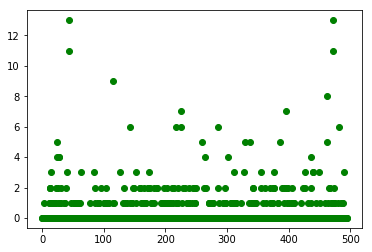

In [132]:
# DecisionTreeRegressor

# Training
feature_cols = [b1, b2, b3, b4, b5, b6]
feature_cols2 = [b8, b9]

X1 = df_data[feature_cols][1:4500]
Y1 = df_data[feature_cols2][1:4500]

# Test
x_test1 = df_data[feature_cols][4501:]
y_test1 = df_data[feature_cols2][4501:]

# Regresion Tree
clf1 = tree.DecisionTreeRegressor()

# Fit
clf1 = clf1.fit(X1, Y1)

# Predict
predicted1 = clf1.predict(x_test1)

# RMSE
rmse1 = sqrt(mean_squared_error(predicted1, y_test1))
print('Test RMSE: %.3f' % rmse1)
# Plot predicted
plt.plot(predicted1, 'go')

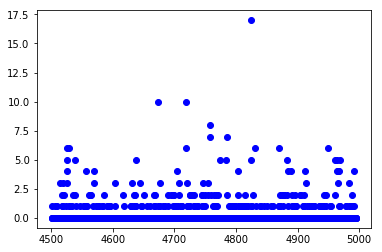

In [133]:
# Plot test
plt.plot(y_test1, 'bo')

Evaluating the quality of the prediction model

## Conclusion: Using the same analysis done for previous model, It can be concluded that the prediction model is able to predict the target with a small error value.

# Other analyzes that can be done with the dataset

(array([  10.,    1.,    1.,    8.,   14.,   33.,   97.,  302.,  304.,
         267.,  327.,  345.,  417.,  415.,  355.,  400.,  311.,  382.,
         376.,  268.,  155.,  116.,   59.,   33.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

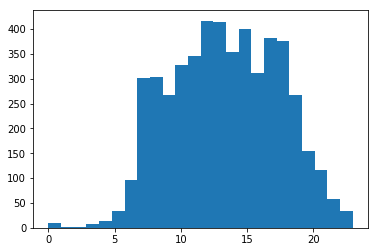

In [138]:
# Histogram representing the distribution of the departures by day time
plt.hist(df_data.start_point_timestamp, bins = 24)

Conclusion: From 6:00AM to 7:00PM the most trips are made

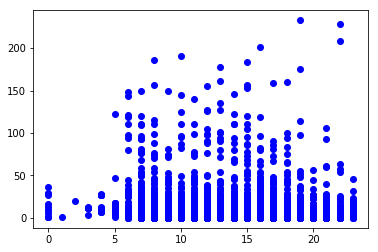

In [137]:
# Distribution of distance traveled by trips that departed at different times of day
plt.plot(df_data.start_point_timestamp, df_data.obd_distance, 'ob')

Conclusion: Most trips travel less than 50 miles

# Graphing on the map

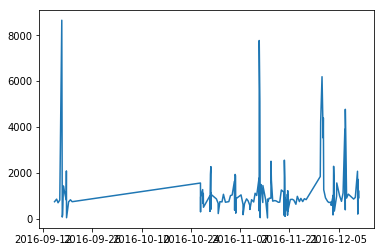

In [147]:
# Duration time of all travels made by device1, ordered by start_point_timestamp
data1 = df_model_dataset.where(col('start_point_latitude')!=0)\
                                    .where(col('start_point_longitude')!=0)\
                                    .where(col('end_point_latitude')!=0)\
                                    .where(col('end_point_longitude')!=0)\
                                    .where(col('duration_seconds')!=0)\
                                    .where(col('obd_distance')!=0)\
            .select('start_point_latitude', 'start_point_longitude', 'end_point_latitude', \
                    'end_point_longitude', 'duration_seconds','start_point_timestamp', \
                    'start_point_daylight_saving_time_flag', 'obd_distance','hard_accel_count',\
                    'hard_brake_count', 'top_speed','top_speed_mph', 'device_key')
            
device1 = data1.where(col('device_key') ==\
                                 'agplfnp1YmllLWV1ciILEgZEZXZpY2UiFjRRQUZQZmVXcWIyeWVoUUxRMkN1aW4M')
pd_device1 = device1.toPandas()
pd_device1['start_point_timestamp'] = pd.to_datetime(pd_device1.start_point_timestamp)
sorted_pd_device1 = pd_device1.sort_values('start_point_timestamp').reset_index()
plt.plot(sorted_pd_device1.start_point_timestamp, sorted_pd_device1.duration_seconds)

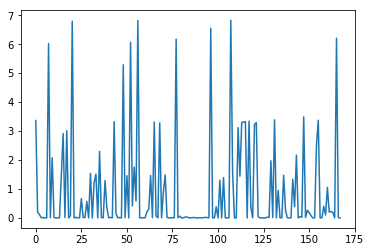

In [151]:
#Distance between the end point of a trip and the starting point of the next trip for the device1
from scipy.spatial.distance import pdist
from geopy.distance import vincenty
import numpy as np

i = 0
distance = []
for i in range(sorted_pd_device1.shape[0]-1):
    if (i > 1):
        coordinates = np.array([[sorted_pd_device1.start_point_latitude[i+1], sorted_pd_device1.start_point_longitude[i+1]],\
                                [sorted_pd_device1.end_point_latitude[i], sorted_pd_device1.end_point_longitude[i]]])
        old_point = (sorted_pd_device1.end_point_latitude[i], sorted_pd_device1.end_point_longitude[i])
        new_point = (sorted_pd_device1.start_point_latitude[i+1], sorted_pd_device1.start_point_longitude[i+1])
        distance.append(vincenty(new_point, old_point).miles)
        #print(vincenty(new_point, old_point).miles)
        i = i + 1
    else:
        i = i + 1
        
plt.plot(distance)

From the analysis above it is possible estimate how optimal is the planning of travels

In [157]:
#Creating the map
import folium 
#fmap=folium.Map(location=[lat_avg , lon_avg], zoom_start=6)
fmap=folium.Map(location=[53.732117, -1.717545], zoom_start=7)

# Plot the travels of device1
new_df = sorted_pd_device1[1:]
i = 0
for row in new_df.iterrows():
    #print(row[1].obd_distance)
    i = i +1
    points = []
    if (row[1].start_point_latitude != 0.0 and row[1].start_point_longitude !=0 and\
        row[1].end_point_latitude != 0.0 and row[1].end_point_longitude != 0.0):
        
        start_latlon = row[1].start_point_latitude, row[1].start_point_longitude
        #folium.Marker(latlon, popup=str(i), icon = folium.Icon(color = 'green')).add_to(fmap)
        #folium.CircleMarker(latlon,radius=10,popup=str(latlon),color='red',fill_color='green').add_to(fmap)
        points.append(tuple([row[1].start_point_latitude, row[1].start_point_longitude]))
        #folium.Marker(start_latlon, popup=str(i), icon=folium.Icon(color='green')).add_to(fmap)
        
        folium.RegularPolygonMarker(start_latlon,
                                    popup=str(start_latlon),
                                    #fill_color='#45647d',
                                    fill_color='green',
                                    number_of_sides=4,
                                    radius=8).add_to(fmap)

        end_latlon = row[1].end_point_latitude, row[1].end_point_longitude
        points.append(tuple([row[1].end_point_latitude, row[1].end_point_longitude]))
        #folium.Marker(end_latlon, popup=str(i), icon=folium.Icon(color='blue')).add_to(fmap)
        folium.RegularPolygonMarker(end_latlon,
                                    popup=str(end_latlon),
                                    #fill_color='#45647d',
                                    fill_color='black',
                                    number_of_sides=4,
                                    radius=8).add_to(fmap)
        folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(fmap)

fmap

# Other analyzes that can be done on this dataset

- As part of the data cleaning process, a matching algorithm can be used to eliminate possible measurement errors from the geolocation capture device
- Compute the average distance traveled by day time
- Compute the average speed by day time
- Compute the average distance traveled by day time and by season (BST and GMT)
- Compute the average travel time by day time
- Clustering data by departure and arrival zipcode
- Build an origin destination matrix
- Histogram of distance and speeds
- Optimization of the minimum path (minimize) between the starting point and the point of origin and the destination